In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import glob
import random
import os
from tifffile import imsave
import splitfolders
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import segmentation_models as sm
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from matplotlib import pyplot as plt
import random
mmscaler = MinMaxScaler()
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
import PIL
from PIL import Image
import copy
import cv2
import glob
import cv2
import os 
from os import path
from skimage.color import lab2rgb
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import MaxPool3d
from torch.nn import AvgPool3d
from torch.nn import Linear, ReLU, MSELoss, Sequential, Conv2d, Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ConvTranspose2d
from torch.optim import Adam, SGD
from math import log10, sqrt
import numpy as np
from skimage.metrics import structural_similarity
import argparse
import imutils
torch.set_default_tensor_type('torch.FloatTensor')

Segmentation Models: using `keras` framework.


In [2]:
train_path_images = 'BraTS2020_TrainingData/input_data_128/train/images'
train_path_masks = 'BraTS2020_TrainingData/input_data_128/train/masks'

In [3]:
all_train_images = []
for file in os.listdir(train_path_images):
    img = np.load(train_path_images+'/'+file)
    all_train_images.append(img)
all_train_images = np.asarray(all_train_images)
all_train_masks = []
for file in os.listdir(train_path_masks):
    img = np.load(train_path_masks+'/'+file)
    all_train_masks.append(img)
all_train_masks = np.asarray(all_train_masks)

In [4]:
all_train_images = torch.tensor(all_train_images)
all_train_masks = torch.tensor(all_train_masks)

In [8]:
class Convnet(nn.Module):   
    def __init__(self):
        super(Convnet, self).__init__()

        self.convolution_layers = Sequential(
            Conv3d(3, 8, kernel_size=3, stride=1, padding=1),
            MaxPool3d(kernel_size=2,stride=2),
            nn.LeakyReLU(),
            Conv3d(8, 16, kernel_size=3, stride=1, padding=1),
            MaxPool3d(kernel_size=2,stride=2),
            nn.LeakyReLU(),
            Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
            MaxPool3d(kernel_size=2,stride=2),
            nn.LeakyReLU(),
            Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            MaxPool3d(kernel_size=2,stride=2),
            nn.LeakyReLU(),
            Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
            MaxPool3d(kernel_size=2,stride=2),
            nn.LeakyReLU()
        )
        
        self.deconvolution_layers = Sequential(
            ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            ConvTranspose3d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            ConvTranspose3d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            ConvTranspose3d(8, 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU()
        )
        


    # Defining the forward pass    
    def forward(self, x):
        x = self.convolution_layers(x)
        x = self.deconvolution_layers(x)
        #print(x.shape)
        return x

In [42]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
device="cpu"
print("Device", device)


batch_size = 2
num_epochs = 5
N=258
learning_rate = 0.01
batches = int(N/batch_size)


model = Convnet()
model = model.float()
model.to(device)

train_data=copy.deepcopy(all_train_images)
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_mask = all_train_masks.to(device)
print("Printing train mask shape")
print(train_mask.shape)
#test_data = copy.deepcopy(test_L)
#test_data = test_data.to(device)
#print("Printing test data shape")
#print(test_data.shape)
#test_ab = test_ab.to(device)
#print("Printing test ab shape")
#print(test_ab.shape)


error = nn.CrossEntropyLoss() # This works well with the linear output layer

dice_l = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) #dice loss
focal_l = sm.losses.CategoricalFocalLoss() #focal loss
total_l = dice_l + (1 * focal_l) #total loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","CrossEntropyLoss")
print(model)

loss_hist = np.zeros(num_epochs)
#loss_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_mask[index*batch_size:(index+1)*batch_size]
        
        train = Variable(patterns.view(batch_size,3,128,128,128))
        train = train.float()
        masks = Variable(labels.view(batch_size,4,128,128,128))
        masks = masks.float()
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(train)
        #loss = error(outputs, masks)
        loss = total_l
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    #patterns = test_data
    #labels = test_ab
    #outputs = model(patterns)
    #is_correct = torch.subtract(labels,outputs)
    #loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    #if epoch%10==0:
    print("Epoch: {}, Loss: {:.7f}".format( epoch, loss_hist[epoch]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Brain Tumor Segmentation")
plt.legend(["Training Loss"])
plt.show()

In [43]:
test_image=all_train_images[0]
test_image=Variable(test_image.view(1,3,128,128,128))
test_image=test_image.float()
test_image=test_image.to(device)
test_image_output=model(test_image)
test_image_output=test_image_output.squeeze()
f = test_image_output.detach()
p=np.array(f.cpu())
data = np.moveaxis(p, 0, 3)
test_seg_mask=np.argmax(data, axis=3)

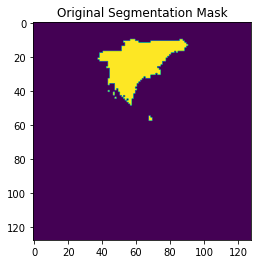

In [38]:
or_seg_mask = np.argmax(all_train_masks[0],axis=3)
plt.imshow(or_seg_mask[:,:,n_slice])
plt.title('Original Segmentation Mask')
plt.show()